# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [3]:
data = pd.read_csv("Examen.csv")
data


Unnamed: 0    producto1    producto2
0             1  4000.000000  3000.000000
1             2  3997.400893  3010.686220
2             3  3978.605317  3022.018584
3             4  3986.454125  3033.920990
4             5  3979.695678  3038.402098
..          ...          ...          ...
122         123  3664.610771  3429.293034
123         124  3650.881839  3437.099467
124         125  3651.788470  3453.155282
125         126  3637.047639  3472.528345
126         127  3641.990873  3476.058092

[127 rows x 3 columns]

# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [4]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

data['Date'] = pd.to_datetime(data['Date'], unit='D', origin='2023-01-01')

data.set_index('Date', inplace=True)
data.head()

producto1    producto2
Date                                
2023-01-02  4000.000000  3000.000000
2023-01-03  3997.400893  3010.686220
2023-01-04  3978.605317  3022.018584
2023-01-05  3986.454125  3033.920990
2023-01-06  3979.695678  3038.402098

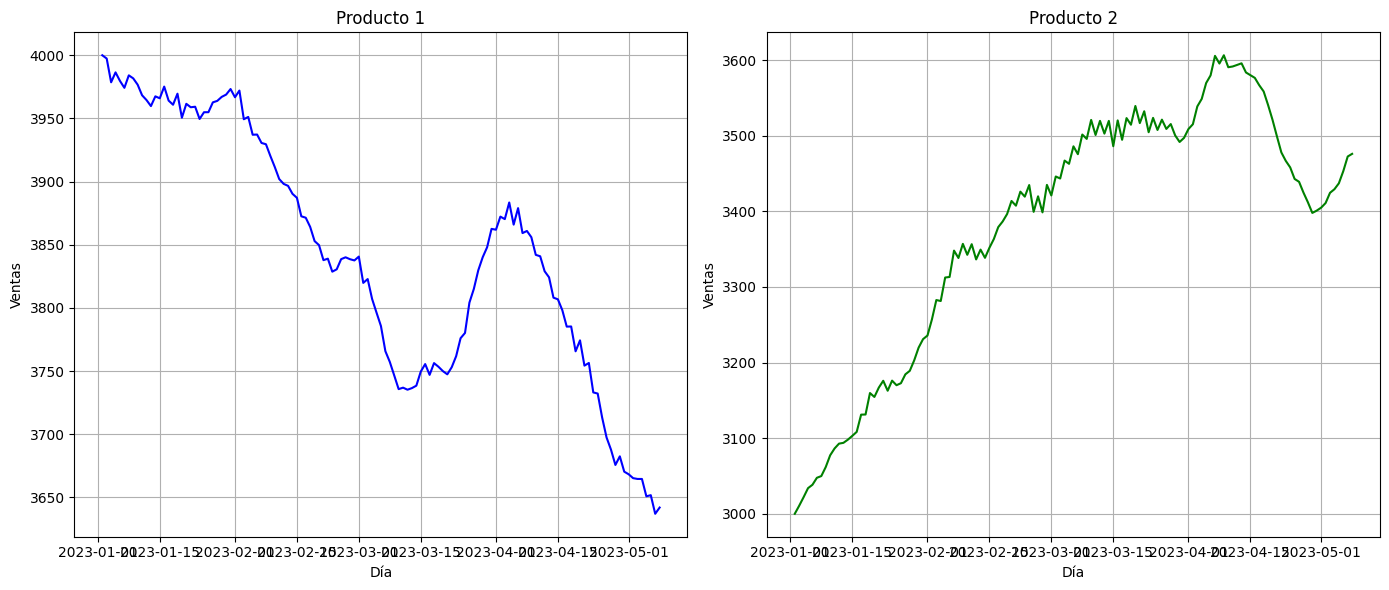

In [5]:



# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data.index, data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data.index, data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [6]:
product_1_df = data[['producto1']]
product_1_df.index = data.index
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data.index



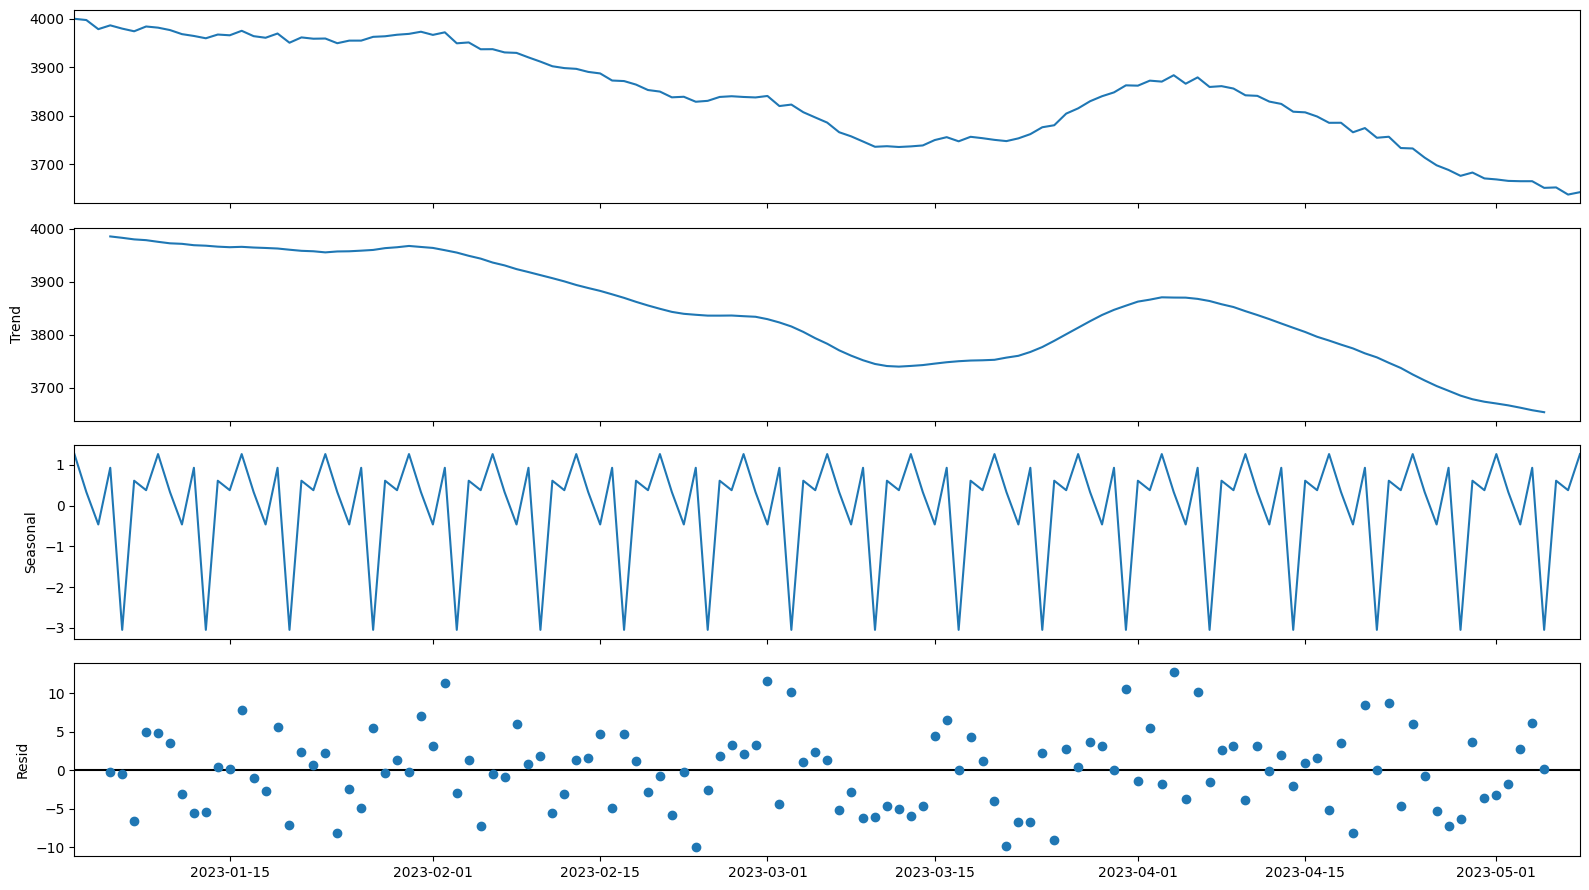

In [7]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

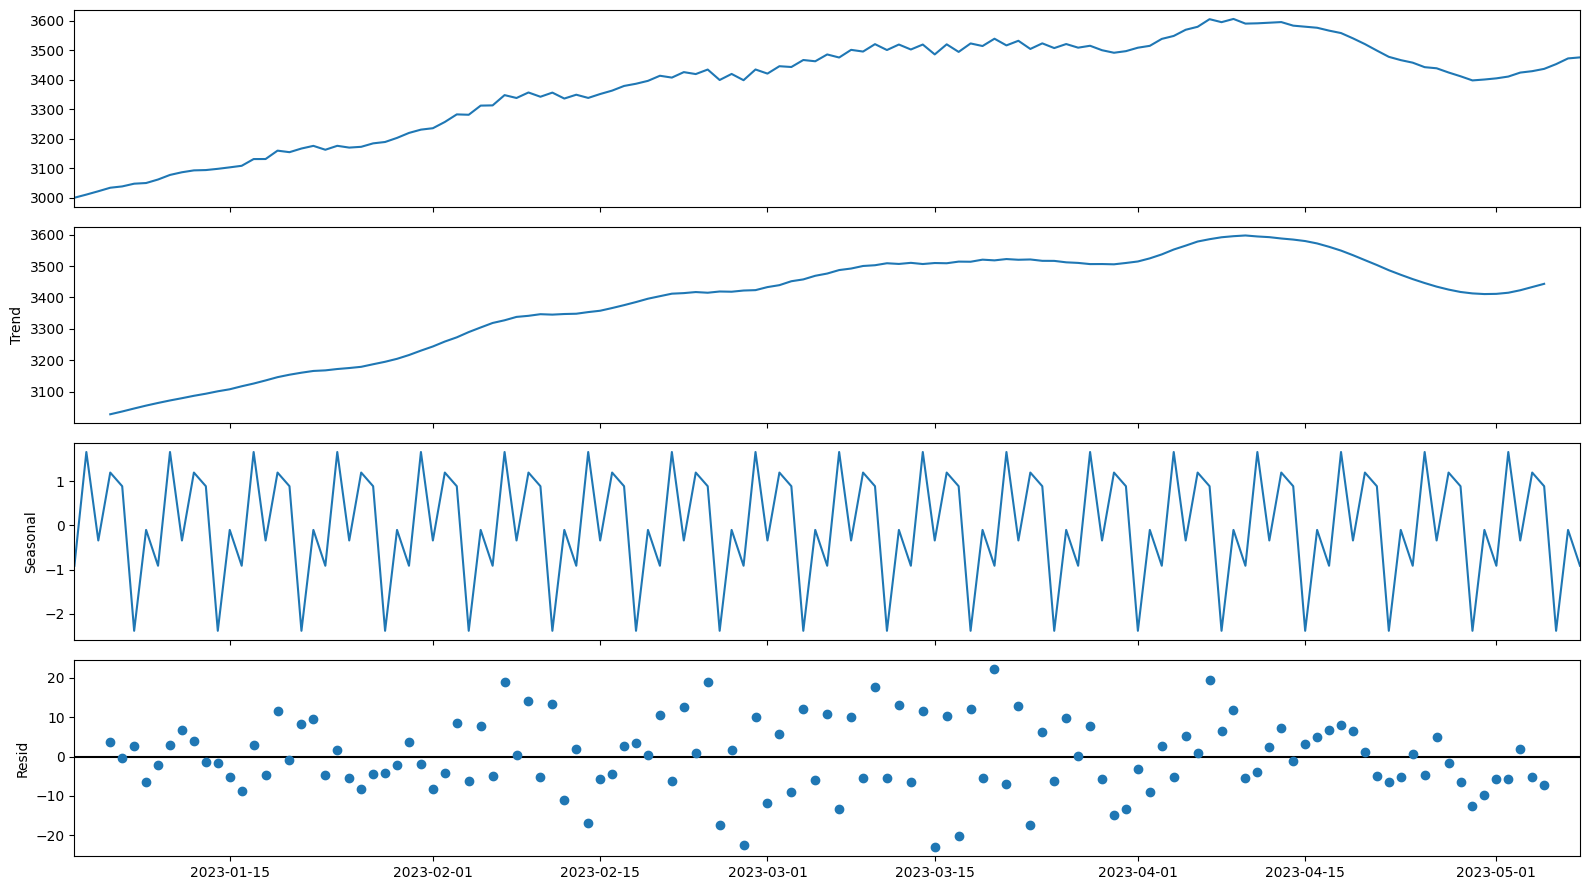

In [8]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [9]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(
    model_class,
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    init_args=None,
    fit_args=None
):
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    # Ensure init_args and fit_args are dictionaries
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate the model with provided init_args
        model = model_class(y_train, **init_args)

        # Fit the model with fit_args if provided
        model_fit = model.fit(**fit_args)

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [11]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full plot with highlighted forecast section
    ax[0].plot(list(range(0, data.shape[0])), data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue', marker='o')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange', marker='o')

    # Adding subtle lines to indicate the delta between actual and forecast
    for i in range(len(forecasts)):
        ax[1].plot([forecast_indices[i], forecast_indices[i]], [data[train_size + i], forecasts[i]], color='red', linestyle='--', linewidth=2)

    ax[1].set_title('Zoomed-In Forecast Section with Delta Lines')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [12]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args={
        'window': 3
	}
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


Promedio móvil RMSE: 9.680204135597737


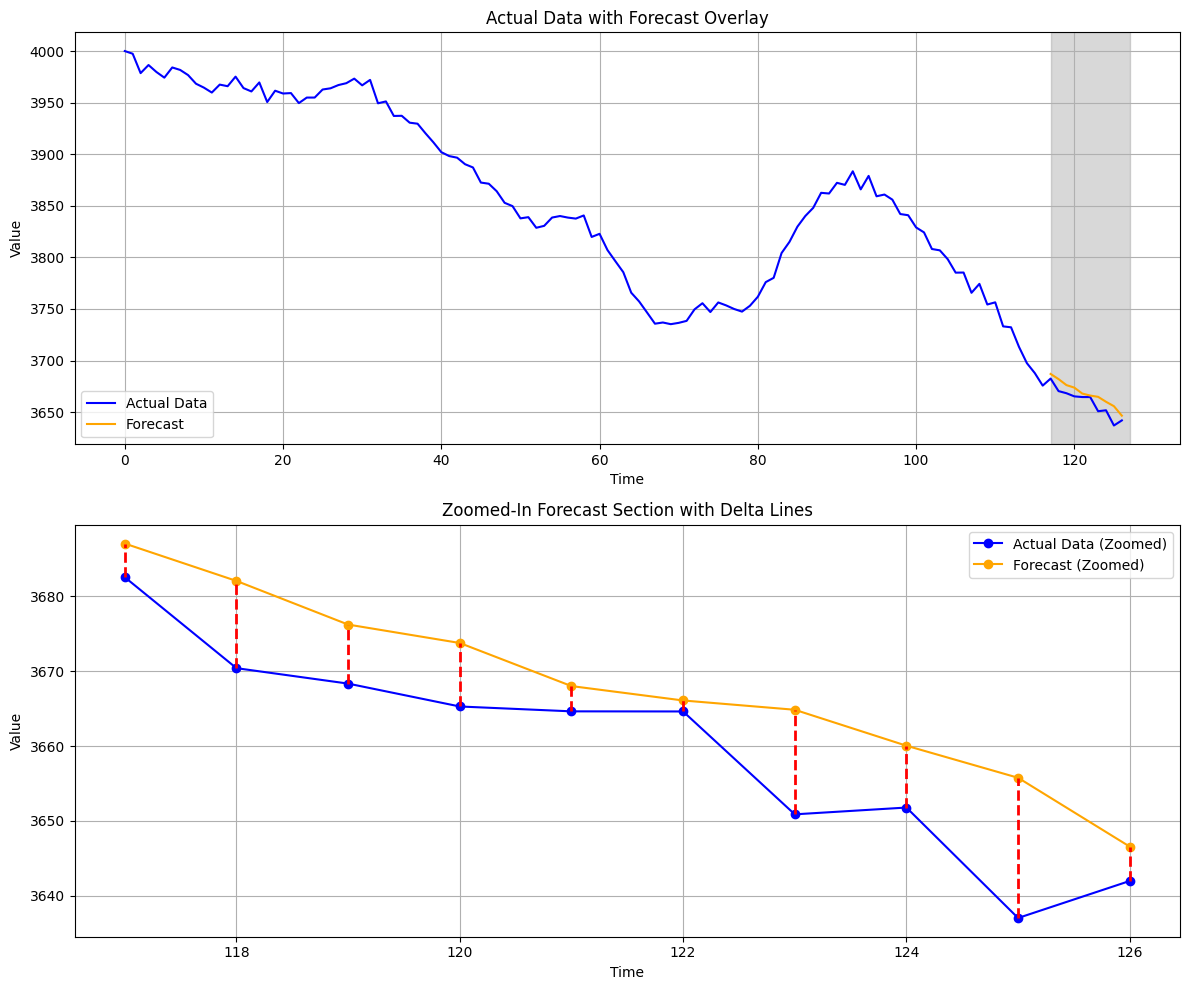

In [13]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [14]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

data_producto1 = data.copy()

data_producto2 = data.copy()

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('D')  # Use daily frequency

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('D')  # Use daily frequency

print(data_producto1.head())
print(data_producto2.head())


              producto1    producto2
Date                                
2023-01-02  4000.000000  3000.000000
2023-01-03  3997.400893  3010.686220
2023-01-04  3978.605317  3022.018584
2023-01-05  3986.454125  3033.920990
2023-01-06  3979.695678  3038.402098
              producto1    producto2
Date                                
2023-01-02  4000.000000  3000.000000
2023-01-03  3997.400893  3010.686220
2023-01-04  3978.605317  3022.018584
2023-01-05  3986.454125  3033.920990
2023-01-06  3979.695678  3038.402098


In [15]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):    
    # Map the parameters (error, trend, seasonal) to actual model components
    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]
    
    # Round and map parameters
    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    init_args = {
        'error': error1[round(error)],
        'trend': trend1[round(trend)],
        'seasonal': seasonal1[round(seasonal)] if seasonal1[round(seasonal)] != "None" else None,
        'seasonal_periods': 7
    }

    fit_args = {
        'smoothing_level': alpha,
        'smoothing_trend': beta if trend1[round(trend)] else None,
        'smoothing_seasonal': gamma if seasonal1[round(seasonal)] else None
    }
    
    # Use rolling window evaluation
    test_errors, forecasts, _ = rolling_window_evaluation(
        model_class=ETSModel,
        data=data_producto1,
        target_column='producto1',
        initial_train_size=train_size,
        num_iterations=iterations,
        forecast_horizon=horizon,
        init_args=init_args,
        fit_args=fit_args
    )
    
    # Compute the average RMSE over all iterations
    avg_rmse = np.sqrt(np.mean(test_errors))

    print(f"Average RMSE: {avg_rmse}, Error: {error1[round(error)]}, Trend: {trend1[round(trend)]}, Seasonal: {seasonal1[round(seasonal)]}, Alpha: {alpha}, Beta: {beta}, Gamma: {gamma}")

    # Return the negative RMSE for Bayesian Optimization (since it maximizes)
    return -avg_rmse


In [16]:
import warnings
warnings.filterwarnings("ignore")

pbounds = {
    'error':  (0, 1),
    'trend': (0, 2),
    'seasonal': (0, 2),
    'alpha': (0.01, 0.99),
    'beta': (0.01, 0.99),
    'gamma': (0.01, 0.99)
}

optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

optimizer.maximize(
    init_points=10,
    n_iter=50
)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18447D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.63645D+00    |proj g|=  2.05626D-01

At iterate    2    f=  3.62645D+00    |proj g|=  1.50756D-01

At iterate    3    f=  3.61723D+00    |proj g|=  1.52883D-01

At iterate    4    f=  3.61378D+00    |proj g|=  4.95323D-02

At iterate    5    f=  3.59899D+00    |proj g|=  8.66321D-02

At iterate    6    f=  3.58706D+00    |proj g|=  8.07664D-02

At iterate    7    f=  3.58685D+00    |proj g|=  1.37916D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    8    f=  3.58243D+00    |proj g|=  1.10624D-01

At ite


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


3.45475D+00    |proj g|=  7.41934D-02

At iterate   49    f=  3.45473D+00    |proj g|=  1.17536D-01

At iterate   50    f=  3.45471D+00    |proj g|=  2.46144D-01

At iterate   51    f=  3.45469D+00    |proj g|=  1.16196D-01

At iterate   52    f=  3.45467D+00    |proj g|=  4.79320D-01

At iterate   53    f=  3.45465D+00    |proj g|=  2.12031D-01

At iterate   54    f=  3.45463D+00    |proj g|=  2.81274D-02

At iterate   55    f=  3.45463D+00    |proj g|=  5.54199D-02

At iterate   56    f=  3.45462D+00    |proj g|=  2.76399D-02

At iterate   57    f=  3.45461D+00    |proj g|=  1.28656D-01

At iterate   58    f=  3.45460D+00    |proj g|=  2.27608D-01

At iterate   59    f=  3.45455D+00    |proj g|=  4.33823D-01

At iterate   60    f=  3.45442D+00    |proj g|=  7.26122D-01

At iterate   61    f=  3.45408D+00    |proj g|=  1.23290D+00

At iterate   62    f=  3.45322D+00    |proj g|=  1.98978D+00

At iterate   63    f=  3.45105D+00    |proj g|=  3.07634D+00

At iterate   64    f=  3.44686D


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12392D+00    |proj g|=  8.99900D-01

At iterate    1    f=  3.74581D+00    |proj g|=  1.38197D-01

At iterate    2    f=  3.74441D+00    |proj g|=  9.49076D-03

At iterate    3    f=  3.74420D+00    |proj g|=  1.82777D-02

At iterate    4    f=  3.74360D+00    |proj g|=  5.77409D-02

At iterate    5    f=  3.74199D+00    |proj g|=  1.27074D-01

At iterate    6    f=  3.73751D+00    |proj g|=  2.25834D-01

At iterate    7    f=  3.71991D+00    |proj g|=  7.26659D-03

At iterate    8    f=  3.70376D+00    |proj g|=  2.80016D-03

At iterate    9    f=  3.70350D+00    |proj g|=  2.49969D-03

At iterate   10    f=  3.70319D+00    |proj g|=  2.46372D-03

At iterate   11    f=  3.70123D+00    |proj g|=  2.63314D-03

At iterate   12    f=  3.69946D+00    |proj g|=  2.47518D-03

At iterate   13    f=  3.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12395D+00    |proj g|=  1.12945D+00

At iterate    1    f=  5.11604D+00    |proj g|=  1.51091D+00

At iterate    2    f=  5.00346D+00    |proj g|=  1.42909D+00

At iterate    3    f=  4.79796D+00    |proj g|=  1.34980D+01

At iterate    4    f=  4.33662D+00    |proj g|=  1.06766D+01

At iterate    5    f=  4.27191D+00    |proj g|=  3.77751D+01

At iterate    6    f=  3.93052D+00    |proj g|=  2.39603D+01

At iterate    7    f=  3.85496D+00    |proj g|=  6.94481D+00

At iterate    8    f=  3.80728D+00    |proj g|=  5.09158D+01

At iterate    9    f=  3.74457D+00    |proj g|=  3.28795D+01

At iterate   10    f=  3.71409D+00    |proj g|=  1.66777D+01

At iterate   11    f=  3.70555D+00    |proj g|=  1.41434D+01

At iterate   12    f=  3.69948D+00    |proj g|=  2.03598D+00

At iterate   13    f=  3.6

In [17]:
optimizer.max

{'target': -7.150008625565331,
 'params': {'alpha': 0.99,
  'beta': 0.99,
  'error': 1.0,
  'gamma': 0.01,
  'seasonal': 0.0,
  'trend': 1.7416685551133473}}

In [18]:
values_map = {0: None, 1: "add", 2: "mul"}

data_copy = data.copy()
data_copy = data_copy.asfreq('D')

init_args = {
    'error': values_map[round(optimizer.max['params']['error'])],
    'trend': values_map[round(optimizer.max['params']['trend'])],
    'seasonal': values_map[round(optimizer.max['params']['seasonal'])],
}

fit_args = {
    'smoothing_level': optimizer.max['params']['alpha'],
    'smoothing_trend': optimizer.max['params']['beta'] if init_args['trend'] else None,
    'smoothing_seasonal': optimizer.max['params']['gamma'] if init_args['seasonal'] else None
}

filtered_init = {k: v for k, v in init_args.items() if v is not None}
filtered_fit = {k: v for k, v in fit_args.items() if v is not None}

test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19435D+00    |proj g|=  1.91011D+01

At iterate    1    f=  5.19068D+00    |proj g|=  1.13353D+01

At iterate    2    f=  5.18778D+00    |proj g|=  8.99689D-01

At iterate    3    f=  5.18593D+00    |proj g|=  3.60690D+00

At iterate    4    f=  5.17414D+00    |proj g|=  1.85432D+01

At iterate    5    f=  5.14876D+00    |proj g|=  3.61187D+01

At iterate    6    f=  5.07550D+00    |proj g|=  6.06786D+01

At iterate    7    f=  4.94659D+00    |proj g|=  7.63741D+01

At iterate    8    f=  4.80251D+00    |proj g|=  7.79110D+01

At iterate    9    f=  4.42043D+00    |proj g|=  6.83327D+01

At iterate   10    f=  3.90979D+00    |proj g|=  5.07244D+01

At iterate   11    f=  3.61932D+00    |proj g|=  2.82476D+01

At iterate   12    f=  3.55479D+00    |proj g|=  1.47204D+01

At iterate   13    f=  3.5

In [19]:
print(f'Best Model: {best_model}')
print(f'Test Errors: {test_errors}')
print(f'Forecasts: {forecasts}')
# rmse
rmse = np.sqrt(np.mean(test_errors))
print(f'RMSE: {rmse}')

Best Model: <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper object at 0x307931730>
Test Errors: [430.19022516680224, 0.3429374214039957, 0.4864925620293646, 1.663606866632874, 2.4175154438864794, 7.4364629702730864, 139.3455170552126, 3.2912021936560056, 66.37229805886844, 115.83368241386383]
Forecasts: [3661.7852288944305, 3670.9756098381567, 3669.025915285056, 3666.5644083916236, 3663.0706355458424, 3661.8837832323975, 3662.6863095400117, 3649.9743025605376, 3645.194558956911, 3631.2282669273222]
RMSE: 8.760022489426776


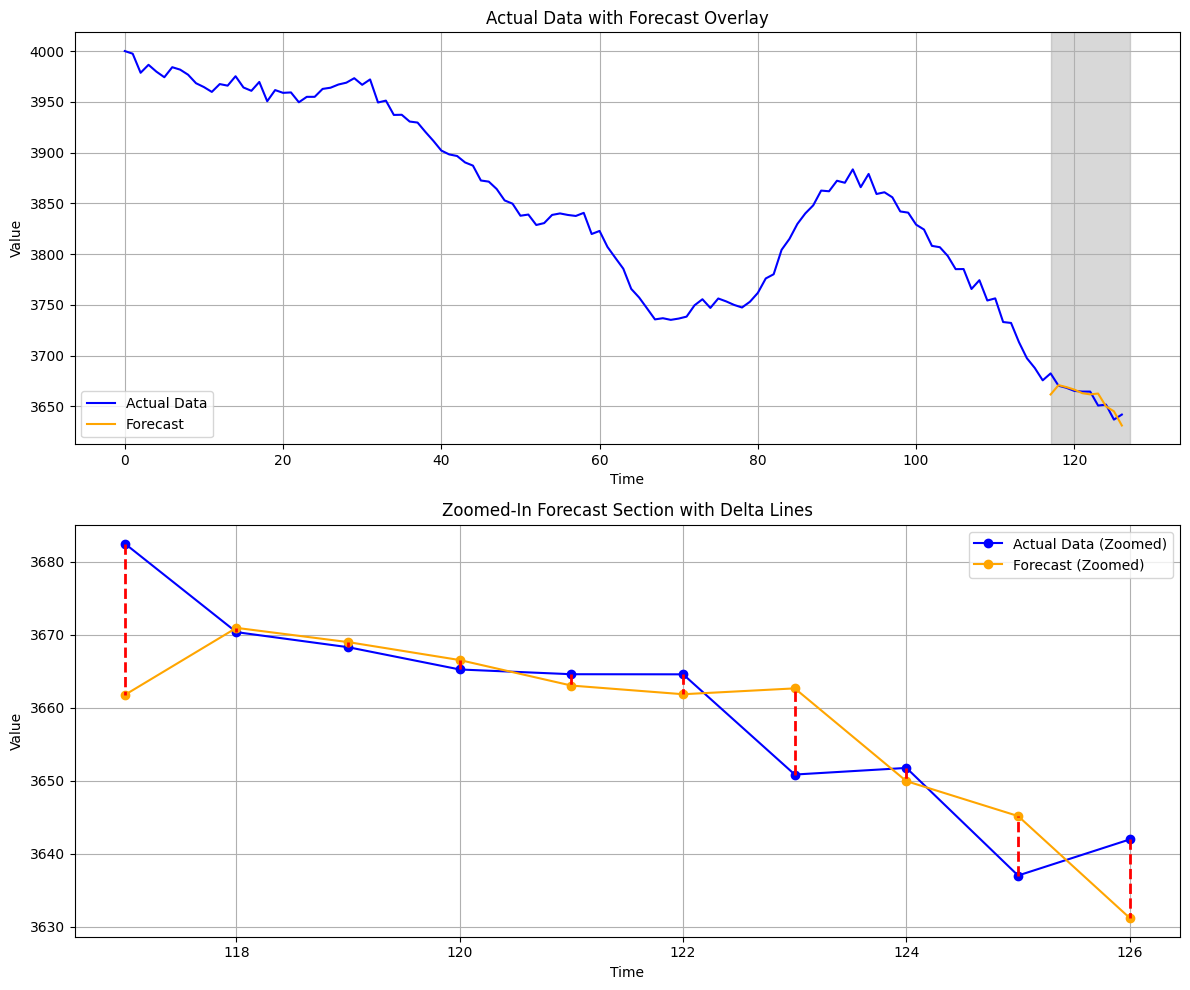

In [20]:
plot_forecast(data['producto1'], forecasts, train_size)

## **5.3 Modelos de Regresión (Tendencia y Estacionalidad)**

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionSeasonalModel:
    def __init__(self, endog, degree, seasonal_periods):
        self.endog = endog
        self.degree = degree  # Degree of the polynomial
        self.seasonal_periods = seasonal_periods  # Number of seasonal periods
        self.model = None  # This will store the LinearRegression model
        self.poly = PolynomialFeatures(degree=self.degree)
        self.fittedvalues = None	
        self.seasonal_dummies = pd.get_dummies(np.arange(self.seasonal_periods) % self.seasonal_periods, drop_first=False)

    def _create_design_matrix(self, y_train, future_steps=None):
        if future_steps is None:
            time_index = np.arange(len(y_train)).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(y_train)) % self.seasonal_periods, drop_first=False)
        else:
            time_index = np.arange(len(self.endog), len(self.endog) + future_steps).reshape(-1, 1)
            seasonality = pd.get_dummies(np.arange(len(self.endog), len(self.endog) + future_steps) % self.seasonal_periods, drop_first=False)

        poly_features = self.poly.fit_transform(time_index)

        seasonality = seasonality.reindex(columns=self.seasonal_dummies.columns, fill_value=0)

        X = np.hstack([poly_features, seasonality])

        return X

    def fit(self):
        # Create the design matrix for the training data
        X_train = self._create_design_matrix(self.endog)

        # Fit the polynomial regression model
        self.model = LinearRegression().fit(X_train, self.endog)
        
        # Store the fitted values
        self.fittedvalues = pd.Series(self.model.predict(X_train), index=self.endog.index)

        return self

    def forecast(self, steps):
        # Create the design matrix for the future steps
        X_future = self._create_design_matrix(self.endog, future_steps=steps)

        # Forecast the next steps
        forecast_values = self.model.predict(X_future)

        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))

In [22]:
best_polynomial_forecasts = []
rmses = []
forecasts = []
lower_RMSE = None

for i in range(1, 20):
	print(f"Polynomial of degree {i}")
	polynomial_test_errors, polynomial_forecasts, polynomial_model = rolling_window_evaluation(
		model_class=PolynomialRegressionSeasonalModel,
		data=data,
		target_column='producto1',
		initial_train_size=train_size,
		num_iterations=iterations,
		forecast_horizon=horizon,
		init_args={
			'degree': i,
			'seasonal_periods': 7
		}
	)
	polynomial_rmse = np.sqrt(np.mean(polynomial_test_errors))
	lower_RMSE = polynomial_rmse if lower_RMSE is None else min(lower_RMSE, polynomial_rmse)
	forecasts.append(polynomial_forecasts)
	if polynomial_rmse == lower_RMSE:
		best_polynomial_forecasts = polynomial_forecasts
	print(f"Polynomial RMSE: {polynomial_rmse}")
	rmses.append(polynomial_rmse)

Polynomial of degree 1
Polynomial RMSE: 55.675678561198104
Polynomial of degree 2
Polynomial RMSE: 84.5918080464048
Polynomial of degree 3
Polynomial RMSE: 64.42115058087214
Polynomial of degree 4
Polynomial RMSE: 67.11019305443017
Polynomial of degree 5
Polynomial RMSE: 96.68212825816893
Polynomial of degree 6
Polynomial RMSE: 34.0527422324109
Polynomial of degree 7
Polynomial RMSE: 43.843289851296646
Polynomial of degree 8
Polynomial RMSE: 40.24397433432629
Polynomial of degree 9
Polynomial RMSE: 18.1476799440538
Polynomial of degree 10
Polynomial RMSE: 16.047194274125033
Polynomial of degree 11
Polynomial RMSE: 12.584842300411939
Polynomial of degree 12
Polynomial RMSE: 14.231719492712685
Polynomial of degree 13
Polynomial RMSE: 24.19275431778403
Polynomial of degree 14
Polynomial RMSE: 56.21960309859819
Polynomial of degree 15
Polynomial RMSE: 101.64735951711397
Polynomial of degree 16
Polynomial RMSE: 153.34132684793005
Polynomial of degree 17
Polynomial RMSE: 204.83689671740373
P

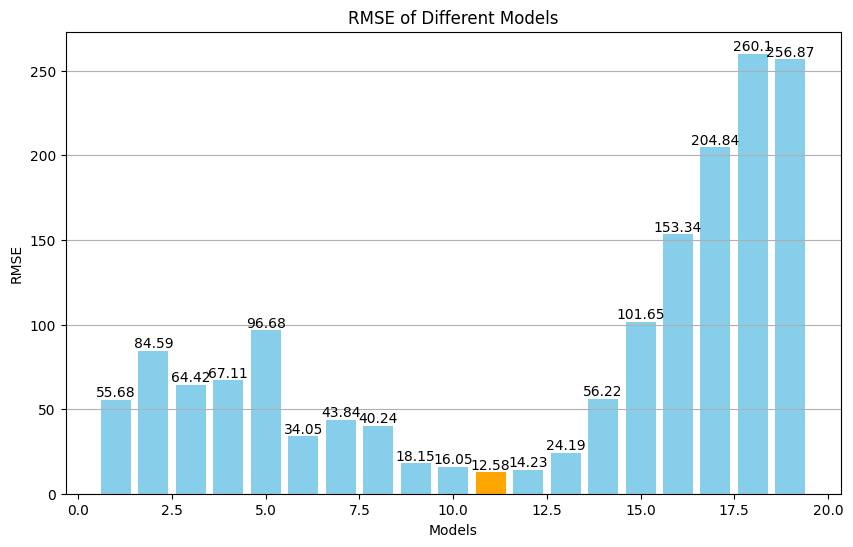

In [23]:
# Identify the index of the lowest RMSE value
min_index = rmses.index(min(rmses))

# Define colors for the bars
colors = ['skyblue' if i != min_index else 'orange' for i in range(len(rmses))]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(rmses) + 1), rmses, color=colors)

# Add numbers below each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of Different Models')
plt.grid(axis='y')

# Display the chart
plt.show()

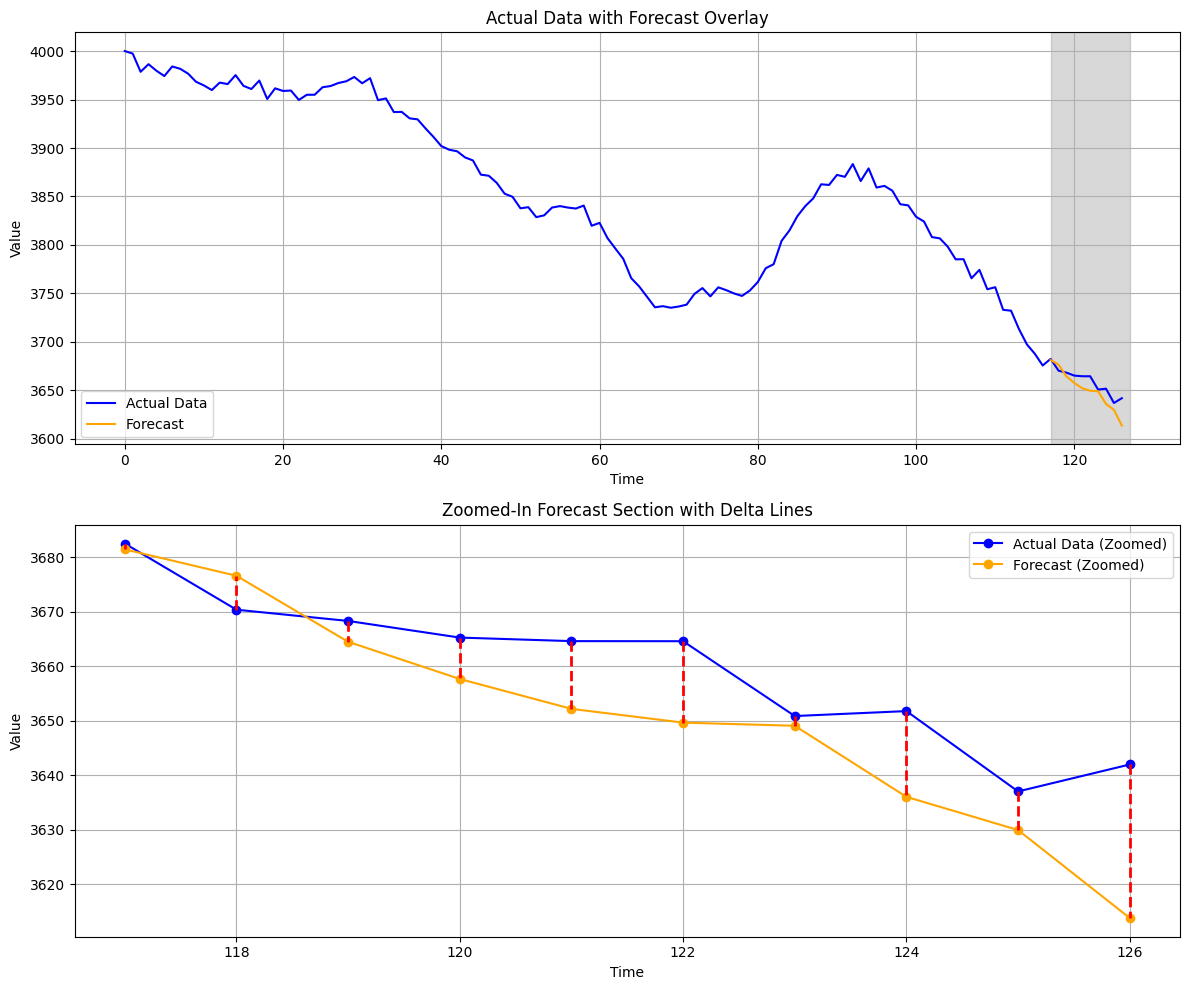

In [24]:
plot_forecast(data['producto1'], best_polynomial_forecasts, train_size)

## **5.4 Modelos ARIMA**

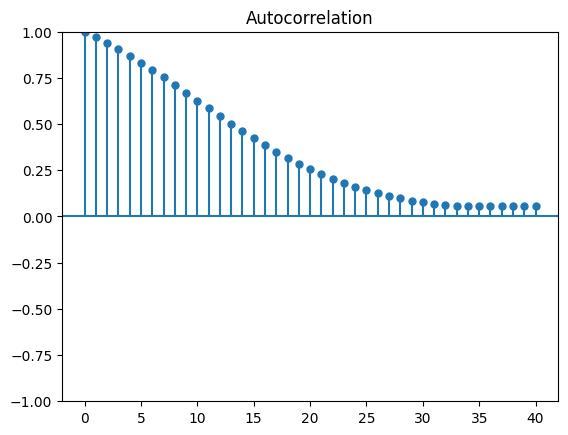

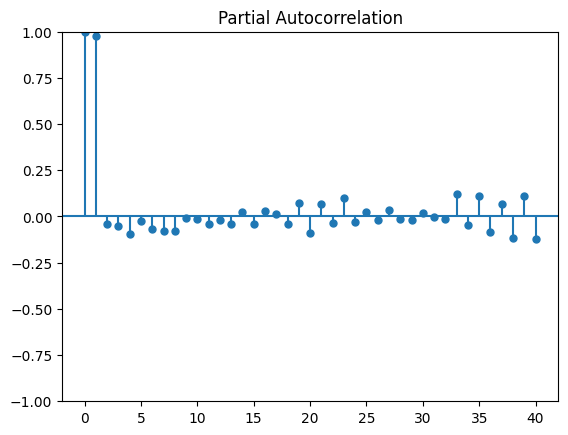

In [25]:
#Gráficas de ACF y PACF

from pmdarima import plot_acf, plot_pacf

plot_acf(data['producto1'],lags=40);
plot_pacf(data['producto1'],lags=40);


### **Estimación de Modelos ARIMA con diferentes Ordenes**

In [63]:
import statsmodels.api as sm

def rolling_window_evaluation_arima(
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    arima_order=None
):
    test_errors = []
    forecasts = []
    best_model = None
    lowest_error = float('inf')

    # Instead of reducing the initial_train_size, iterate from where the rolling window starts
    for i in range(num_iterations):
        train_start = 0  # Always start from the beginning of the data
        train_end = initial_train_size + i  # Increase the window with each iteration
        test_start = train_end
        test_end = test_start + forecast_horizon

        # Make sure we do not go out of bounds in the data
        if test_end > len(data):
            break

        train_window = data.iloc[train_start:train_end]
        test_window = data.iloc[test_start:test_end]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Fit ARIMA model
        model = sm.tsa.ARIMA(y_train, order=arima_order)
        model_fit = model.fit()

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(steps=forecast_horizon)

        # Handle Series or array as prediction output
        if isinstance(test_predictions, pd.Series):
            forecasts.append(test_predictions.values[0])
        else:
            forecasts.append(test_predictions[0])

        # Calculate the test error
        test_error = mean_squared_error(y_test[:len(test_predictions)], test_predictions)
        test_errors.append(test_error)

        # Save the best model
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model

In [64]:
def evaluate_multiple_arima_orders(data, target_column, initial_train_size, num_iterations, forecast_horizon, orders_list):
    results = {}

    for order in orders_list:
        print("\n" + "="*40)  # Separator for clarity
        print(f"Evaluating ARIMA{order}...")
        print("="*40)

        test_errors, forecasts, best_model = rolling_window_evaluation_arima(
            data,
            target_column,
            initial_train_size,
            num_iterations,
            forecast_horizon,
            arima_order=order
        )

        # Calculate the average RMSE
        rmse_mean = np.sqrt(np.mean(test_errors))

        # Store the results
        results[order] = {
            'RMSE_Mean': rmse_mean,
            'Best_Model': best_model
        }

        # Print the results for each order
        print(f"ARIMA Order: {order}")
        print(f"Average RMSE: {rmse_mean:.4f}")
        if best_model:
            print("Best Model Summary:")
            print(best_model.summary())
        else:
            print("No suitable model found.")

    return results

In [48]:
def plot_rmse_comparison(results):
    orders = [str(order) for order in results.keys()]
    rmse_means = [metrics['RMSE_Mean'] for metrics in results.values()]
    
    colors = ['skyblue' if i['RMSE_Mean'] > min([x['RMSE_Mean'] for x in results.values()]) else 'orange' for i in results.values()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(orders, rmse_means, color=colors)
    plt.xlabel('Orden ARIMA')
    plt.ylabel('RMSE Promedio')
    plt.title('Comparación del RMSE Promedio para Diferentes Órdenes ARIMA')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Agregar etiquetas a las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            yval + 0.01,  # Posicionar la etiqueta justo encima de la barra
            f'{yval:.4f}',
            ha='center',
            va='bottom'
        )

    plt.show()

In [65]:
lista_ordenes_probar = [
    (1, 1, 1), (1, 1, 2), (1, 1, 3),
    (1, 2, 1), (1, 2, 2), (1, 2, 3),
    (1, 3, 1), (1, 3, 2), (1, 3, 3),
    (2, 1, 1), (2, 1, 2), (2, 1, 3),
    (2, 2, 1), (2, 2, 2), (2, 2, 3),
    (2, 3, 1), (2, 3, 2), (2, 3, 3),
    (3, 1, 1), (3, 1, 2), (3, 1, 3),
    (3, 2, 1), (3, 2, 2), (3, 2, 3),
    (3, 3, 1), (3, 3, 2), (3, 3, 3)
]

In [66]:
results = evaluate_multiple_arima_orders(
    data,
    'producto1',
    initial_train_size=train_size,  # You can change the window size
    num_iterations=iterations,
    forecast_horizon=horizon,
    orders_list=lista_ordenes_probar
)


Evaluating ARIMA(1, 1, 1)...
ARIMA Order: (1, 1, 1)
Average RMSE: 8.4946
Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:              producto1   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -430.375
Date:                Sat, 07 Sep 2024   AIC                            866.750
Time:                        13:45:39   BIC                            875.087
Sample:                    01-02-2023   HQIC                           870.135
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9299      0.060     15.585      0.000       0.813       1.047
ma.L1         -0.7565      0.116     

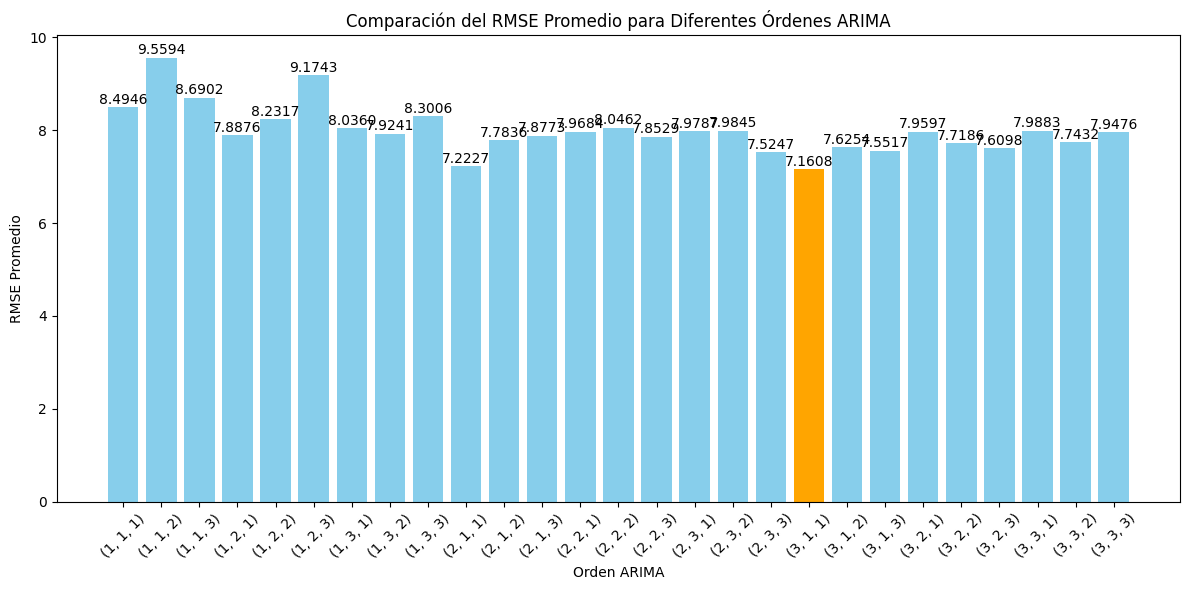

In [67]:
# Graficar los resultados
plot_rmse_comparison(results)

In [72]:
results[(1, 2, 1)]["Best_Model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              producto1   No. Observations:                  124
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -421.565
Date:                Sat, 07 Sep 2024   AIC                            849.129
Time:                        13:46:39   BIC                            857.541
Sample:                    01-02-2023   HQIC                           852.546
                         - 05-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6852      0.086     -7.954      0.000      -0.854      -0.516
ma.L1         -0.3750      0.118     -3.171      0.002      -0.607      -0.143
sigma2        58.1047      7.835      7.417      0.000      42.749      73.460
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.71   Prob(JB):                         0.58
Heteroskedasticity (H):               0.91   Skew:                            -0.23
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
# Ejemplo de uso
final_results = evaluate_multiple_arima_orders(
    data,
    'producto1',
    initial_train_size=24,
    num_iterations=10,
    forecast_horizon=1,
    orders_list=[(2, 1, 1)]
)


Evaluating ARIMA(2, 1, 1)...
ARIMA Order: (2, 1, 1)
Average RMSE: 8.7261
Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:              producto1   No. Observations:                   24
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -79.182
Date:                Sat, 07 Sep 2024   AIC                            166.363
Time:                        13:48:00   BIC                            170.905
Sample:                    01-02-2023   HQIC                           167.506
                         - 01-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3279      0.460     -2.885      0.004      -2.230      -0.426
ar.L2         -0.5019      0.269     

In [112]:
final_results

{(2, 1, 1): {'RMSE_Mean': 8.726104763700741,
  'Best_Model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x32245b850>}}

In [113]:
residuals = final_results[(2,1,1)]['Best_Model'].resid.iloc[1:]

In [114]:
len(residuals)

23

In [115]:
residuals = residuals.to_numpy()

In [116]:
len(residuals)

23

In [117]:
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

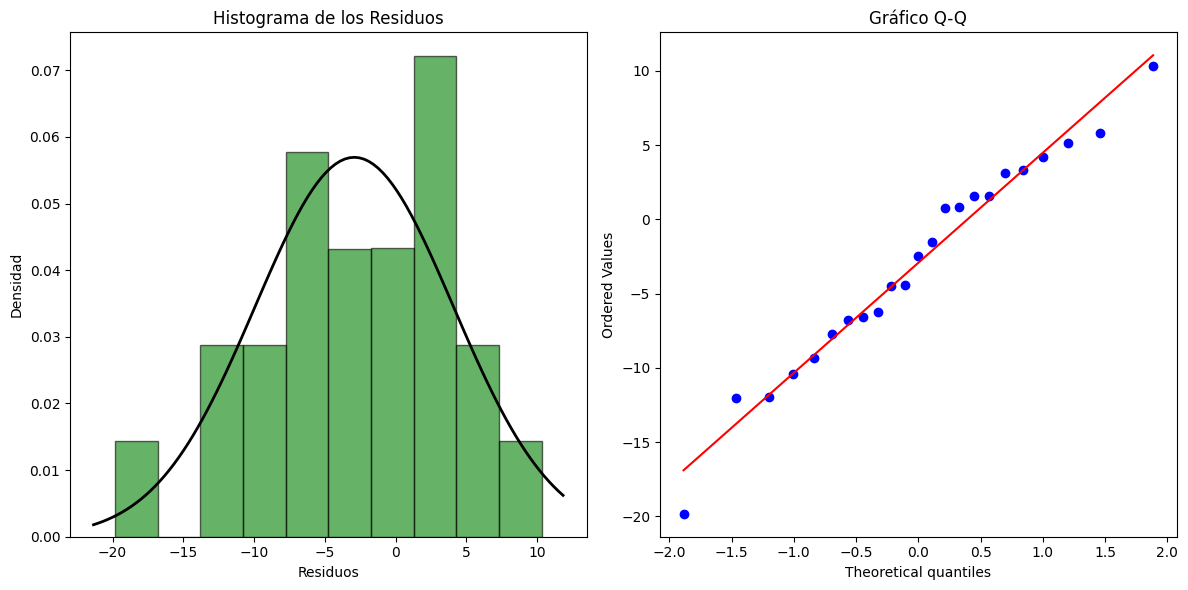

In [118]:
# Calcular parámetros de la distribución normal ajustada
mu, std = stats.norm.fit(residuals)

# Crear subgráficas
plt.figure(figsize=(12, 6))

# Histograma de los residuos con ajuste de línea normal
plt.subplot(121)
plt.hist(residuals, edgecolor='k', density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()  # Limites del histograma
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histograma de los Residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidad")

# Gráfico Q-Q
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q")

# Mostrar gráficos
plt.tight_layout()
plt.show()

Durbin-Watson Statistic: 1.89
Shapiro-Wilk Test: p-value = 0.8592


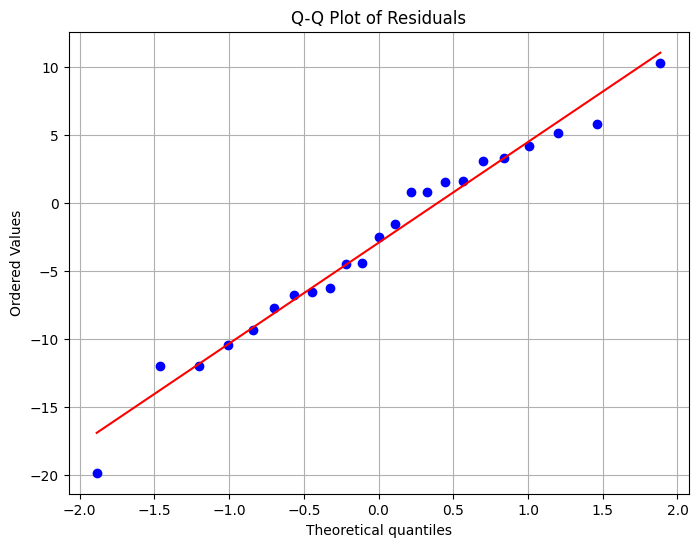

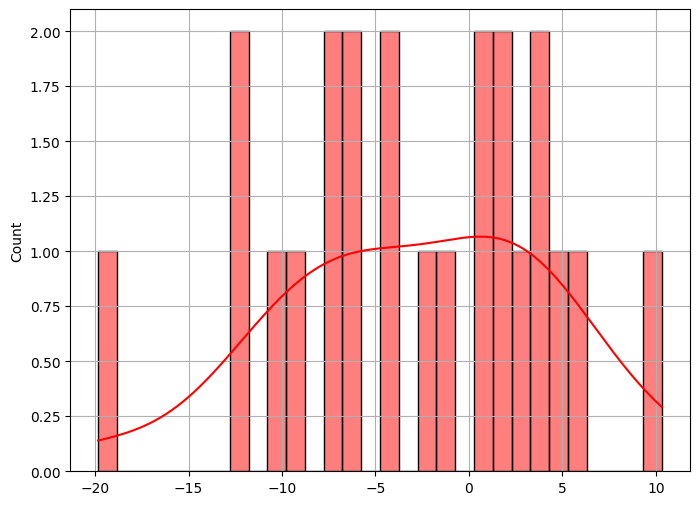

In [119]:



dw_stat = sm.stats.durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.2f}")


# 3. Normality - Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: p-value = {shapiro_test.pvalue:.4f}")

# Q-Q plot for normality check
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='r', edgecolor='k')
plt.grid(True)
plt.show()



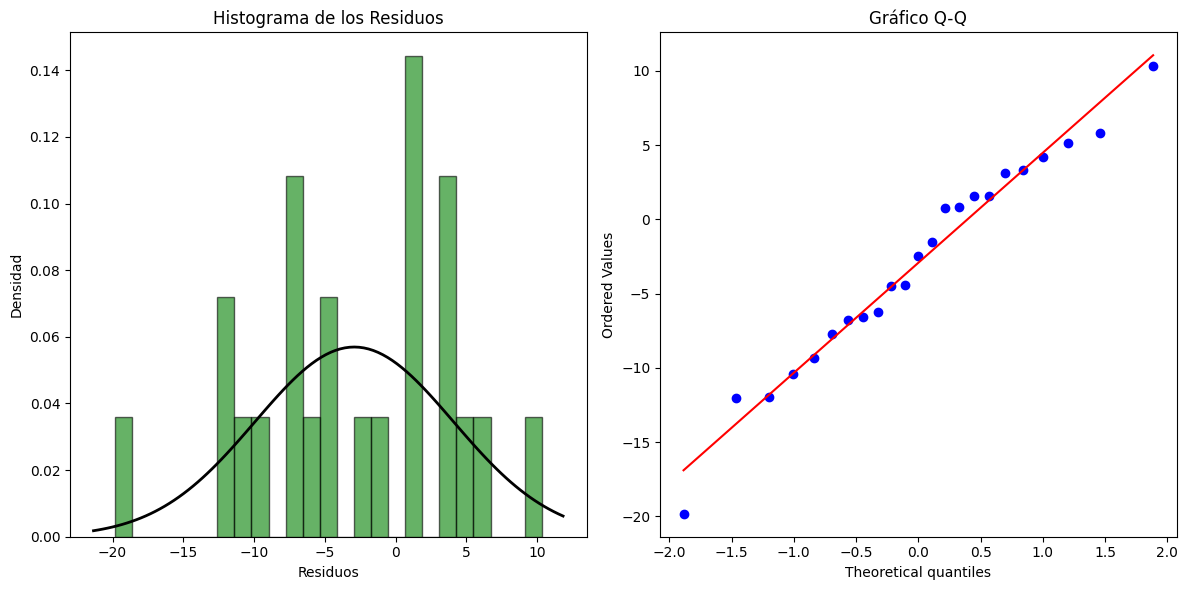

In [120]:
from scipy import stats
# Calcular parámetros de la distribución normal ajustada
mu, std = stats.norm.fit(residuals)

# Crear subgráficas
plt.figure(figsize=(12, 6))

# Histograma de los residuos con ajuste de línea normal
plt.subplot(121)
plt.hist(residuals, bins=25, edgecolor='k', density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()  # Limites del histograma
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histograma de los Residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidad")

# Gráfico Q-Q
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q")

# Mostrar gráficos
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

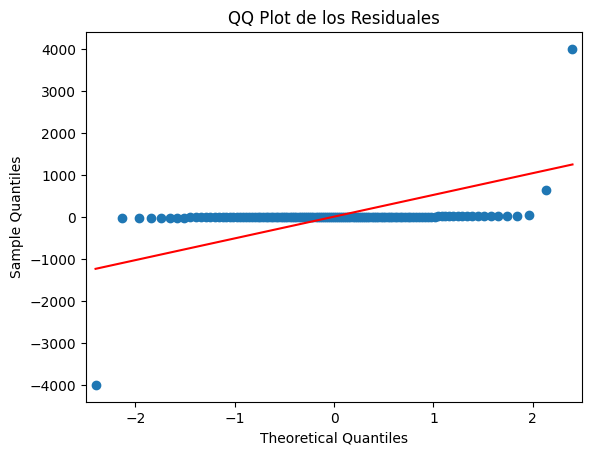

In [121]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Suponiendo que 'best_model_arima_131' es tu modelo ajustado para (1, 3, 1)
best_model_arima_131 = results[(1, 3, 1)]['Best_Model']

# Obtener los residuales del modelo
residuals = best_model_arima_131.resid

# Crear el QQ plot
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
plt.title('QQ Plot de los Residuales')
plt.show()